# XGBoost Classification Demo: UCI Bank Marketing Dataset

## Introduction

In this notebook, we demonstrate the use of **XGBoost** for classifying whether a bank client will subscribe to a term deposit using the UCI Bank Marketing Dataset. Our objective is to build a classification model that predicts the outcome based on client and campaign attributes.

https://archive.ics.uci.edu/dataset/222/bank+marketing

In [3]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install -U graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 602.8 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [26]:
import xgboost
print(xgboost.__version__)

3.0.0


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

import xgboost as xgb

## Load and Prepare Data

We load the dataset from `uci_bank_data.csv` and perform data cleaning and preprocessing

#### **Client-related attributes:**
- `age`: Age of the client (numeric)
- `job`: Type of job (categorical: e.g., admin., technician, unemployed)
- `marital`: Marital status (categorical: married, single, divorced)
- `education`: Education level (categorical: e.g., primary, secondary, tertiary)
- `default`: Has credit in default? (binary: yes/no)
- `balance`: Average yearly balance in euros (numeric)
- `housing`: Has housing loan? (binary: yes/no)
- `loan`: Has personal loan? (binary: yes/no)

#### **Campaign-related attributes:**
- `contact`: Contact communication type (categorical: cellular, telephone)
- `day`: Last contact day of the month (numeric)
- `month`: Last contact month (categorical)
- `duration`: Last contact duration in seconds (numeric)  
  **(Important: This feature is highly predictive but should be handled carefully in model building.)**

#### **Previous campaign attributes:**
- `campaign`: Number of contacts during this campaign (numeric)
- `pdays`: Days since last contact in a previous campaign (-1 means never contacted)
- `previous`: Number of contacts before this campaign (numeric)
- `poutcome`: Outcome of the previous campaign (categorical)

---

### **Output Variable**
- `y`: Has the client subscribed to a term deposit? (binary: yes/no)


In [23]:
bank_data = pd.read_csv("uci_bank_data.csv")

bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [24]:
bank_data.shape

(45211, 17)

In [25]:
bank_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Duration

last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. 

Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [27]:
bank_data.drop(columns=['duration'], inplace=True)

bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


XGBoost only accepts numbers in the target - we need to convert our yes/no values to numeric representations

In [28]:
bank_data['target'] = bank_data['y'].map({'no': 0, 'yes': 1})

bank_data.drop(columns=['y'], inplace=True)

bank_data.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,target
9777,39,management,married,primary,no,1873,no,no,unknown,9,jun,2,-1,0,unknown,0
39006,32,technician,single,secondary,no,55,yes,no,cellular,18,may,1,-1,0,unknown,0
17239,48,technician,married,secondary,no,759,yes,no,cellular,28,jul,5,-1,0,unknown,0
34008,29,management,married,tertiary,no,125,no,no,cellular,30,apr,2,-1,0,unknown,0
5724,37,admin.,married,secondary,no,-255,yes,no,unknown,26,may,2,-1,0,unknown,0


Highly imbalanced dataset

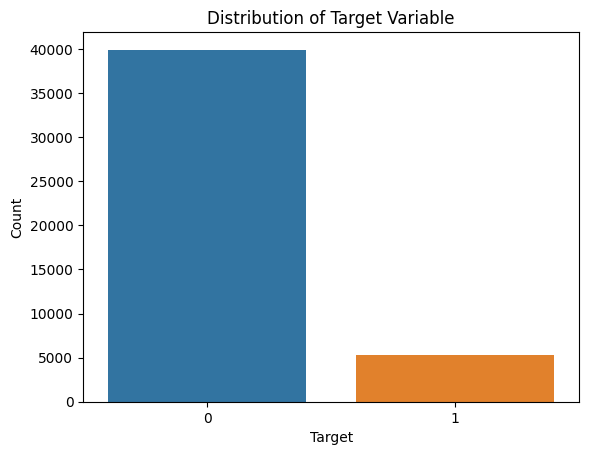

In [29]:
target_counts = bank_data['target'].value_counts()

sns.barplot(x=target_counts.index, y=target_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

### Automatic encoding of categorical variables

This is supported in recent versions of XGBoost - 1.3+ under certain conditions

- You're using pandas DataFrames (not NumPy arrays).
- The categorical columns are marked with pandas category dtype.
- You're using tree-based boosters 
- You use tree_method='hist' or tree_method='gpu_hist'

In [31]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  target     45211 non-null  int64 
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


In [30]:
categorical_variables = bank_data.select_dtypes(exclude=np.number).columns.tolist()

categorical_variables

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [32]:
for col in categorical_variables:
    bank_data[col] = bank_data[col].astype('category')

bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  campaign   45211 non-null  int64   
 12  pdays      45211 non-null  int64   
 13  previous   45211 non-null  int64   
 14  poutcome   45211 non-null  category
 15  target     45211 non-null  int64   
dtypes: category(9), int64(7)
memory usage: 2.8 MB


In [34]:
X = bank_data.drop('target', axis=1)

y = bank_data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

X_train.shape, X_test.shape

((31647, 15), (13564, 15))

## Create and Train XGBoost Model

In [53]:
xgb_clf = xgb.XGBClassifier(
    booster = 'gbtree',
    n_estimators = 300,
    enable_categorical=True, 
    objective='binary:logistic', 
    tree_method='hist',
    eval_metric='auc',
    random_state=42
)

xgb_clf.fit(X_train, y_train)

print("XGBoost model trained successfully.")

XGBoost model trained successfully.


## Evaluate the Model Output

We generate predictions on the test set and evaluate the model using the following metrics:
- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**

In [54]:
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Evaluation Metrics:")
print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

Evaluation Metrics:
Accuracy: 0.8904
Precision: 0.5637
Recall: 0.2817
F1 Score: 0.3756


In [60]:
from collections import Counter
counts = Counter(y_train)
scale = counts[0] / counts[1]

scale

7.548622366288493

In [61]:
xgb_clf = xgb.XGBClassifier(
    booster = 'gbtree',
    n_estimators = 300,
    enable_categorical=True, 
    objective='binary:logistic', 
    tree_method='hist',
    eval_metric='auc',
    scale_pos_weight=scale,
    random_state=42
)

xgb_clf.fit(X_train, y_train)

print("XGBoost model trained successfully.")

XGBoost model trained successfully.


In [62]:
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Evaluation Metrics:")
print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

Evaluation Metrics:
Accuracy: 0.8538
Precision: 0.3898
Recall: 0.4411
F1 Score: 0.4138


## Show Feature Importance Scores

We extract and visualize the feature importance scores provided by XGBoost to understand which features contribute most to the model..

In [63]:
importances = xgb_clf.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': features, 'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
14,poutcome,0.261771
8,contact,0.116258
6,housing,0.094421
10,month,0.084538
7,loan,0.050513
1,job,0.050151
2,marital,0.046065
9,day,0.044955
0,age,0.039353
4,default,0.037820


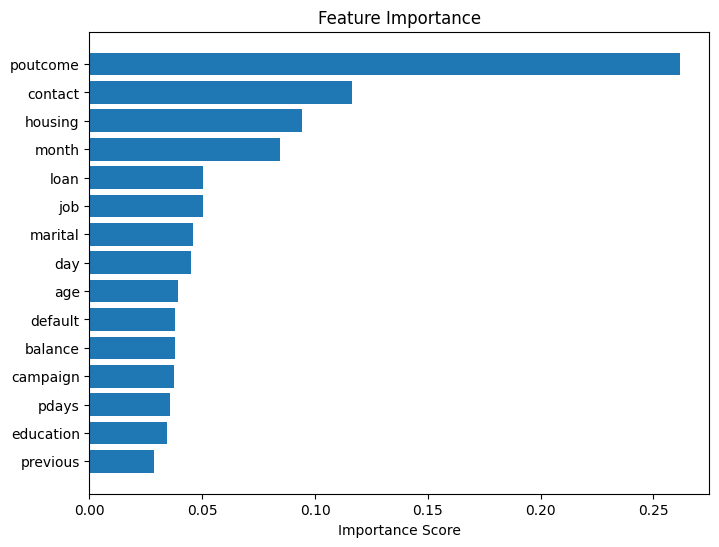

In [72]:
plt.figure(figsize=(8, 6))

plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance Score")
plt.title("Feature Importance")

# highest importance on top
plt.gca().invert_yaxis()  
plt.show()

## Try Different Regularization Parameters

We explore the effect of different regularization parameters on model performance. Here, we experiment with:
- **gamma:** Minimum loss reduction required to make a split
- **reg_lambda:** L2 regularization term
- **reg_alpha:** L1 regularization term

Several models with varying parameters are trained and their performance metrics are compared.

In [65]:
def train_evaluate_model(params):
    model = xgb.XGBClassifier(
        booster = 'gbtree',
        n_estimators = 300,
        enable_categorical=True, 
        objective='binary:logistic', 
        tree_method='hist',
        eval_metric='auc',
        scale_pos_weight=scale,
        random_state=42,
        **params
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1s = f1_score(y_test, preds)
    
    return acc, prec, rec, f1s

Note that with very strong regularization we are able to improve the recall of the model

In [66]:
params_list = [
    # Baseline (very low regularization)
    {"gamma": 0, "reg_lambda": 1, "reg_alpha": 0},

    # Regularization via L1 and L2
    {"gamma": 0.1, "reg_lambda": 2, "reg_alpha": 1},

    # Balanced L1/L2 with moderate gamma
    {"gamma": 0.3, "reg_lambda": 2, "reg_alpha": 0.5}
]

results = []

for params in params_list:
    acc, prec, rec, f1s = train_evaluate_model(params)
    results.append({"Parameters": params, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1_Score": f1s})

results_df = pd.DataFrame(results)

print("Regularization Parameter Experiment Results:")
results_df

Regularization Parameter Experiment Results:


,Parameters,Accuracy,Precision,Recall,F1_Score
0,"{'gamma': 0, 'reg_lambda': 1, 'reg_alpha': 0}",0.853804,0.389755,0.441084,0.413834
1,"{'gamma': 0.1, 'reg_lambda': 2, 'reg_alpha': 1}",0.853141,0.391537,0.460618,0.423277
2,"{'gamma': 0.3, 'reg_lambda': 2, 'reg_alpha': 0.5}",0.839354,0.370289,0.532451,0.436805


## Implement Early Stopping

Early stopping helps prevent overfitting by stopping training when performance on a validation set stops improving. A portion of the training data is set aside for validation, and `early_stopping_rounds` is used during training.


In [67]:
X_train_es, X_val, y_train_es, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

X_train_es.shape, X_val.shape, X_test.shape

((25317, 15), (6330, 15), (13564, 15))

In [69]:
dtrain = xgb.DMatrix(X_train_es, label=y_train_es, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [70]:
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'scale_pos_weight': scale,
    'random_state': 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,  # Set a large number of rounds
    evals=[(dval, 'validation')],
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	validation-auc:0.75216
[1]	validation-auc:0.76933
[2]	validation-auc:0.77730
[3]	validation-auc:0.78746
[4]	validation-auc:0.78597
[5]	validation-auc:0.78864
[6]	validation-auc:0.78843
[7]	validation-auc:0.78542
[8]	validation-auc:0.78698
[9]	validation-auc:0.79032
[10]	validation-auc:0.78825
[11]	validation-auc:0.78734
[12]	validation-auc:0.78376
[13]	validation-auc:0.78311
[14]	validation-auc:0.78471
[15]	validation-auc:0.78354
[16]	validation-auc:0.78269
[17]	validation-auc:0.78272
[18]	validation-auc:0.78226
[19]	validation-auc:0.78348


In [74]:
y_pred_es = model.predict(dtest)
y_pred_es = [round(value) for value in y_pred_es]  

print("Accuracy:", round(accuracy_score(y_test, y_pred_es), 4))
print("Precision:", round(precision_score(y_test, y_pred_es), 4))
print("Recall:", round(recall_score(y_test, y_pred_es), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_es), 4))

Accuracy: 0.8219
Precision: 0.3506
Recall: 0.6131
F1 Score: 0.4461


## Implement Cross-validation

Cross-validation is a technique used to assess how well a machine learning model generalizes to unseen data by splitting the training data into multiple subsets (folds). The model is trained on some folds and validated on the remaining fold(s), rotating through all combinations to get a more reliable estimate of performance.

Note we use the entire training data (we do not have a separate validation set)

In [75]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [76]:
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'scale_pos_weight': scale,
    'random_state': 42
}

results = xgb.cv(
    params,
    dtrain,
    nfold=5,
    num_boost_round=30
)

results.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.772374,0.002845,0.748937,0.009550
1,0.789500,0.002613,0.764666,0.011221
2,0.801197,0.002813,0.777304,0.011722
3,0.809052,0.002907,0.783197,0.011822
4,0.815132,0.002268,0.786704,0.010074
